- MLP
- Multiple countries
- Trained on the whole sequence, not autoregressive

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [2]:
# Load the CSV file
path = "data/COVID_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country_waves = {"Republic of Korea": {1: [15, 123],
                                   2: [206, 295],
                                   3: [289, 436],
                                   4: [533, 652], #좀 애매함
                                   5: [736, 897],
                                   6: [897, 1010],
                                   7: [1010, 1164] #wave가 애매하게 2개임
                                   },
            "China": {1: [0, 74],
                      2: [66, 119],
                      3: [154, 266],
                      4: [316, 413], #wave가 살짝 2개에 가까움
                      5: [484, 561],
                      6: [1065, 1119],
                      },
            "United Kingdom of Great Britain and Northern Ireland": {1: [52, 184],
                                                                     2: [192, 486], #wave가 2개라서 아래의 3,4번에서 2개로 나눠도 봄.
                                                                     3: [192, 330], #2번의 앞쪽 wave
                                                                     4: [331, 486], #2번의 뒤쪽 wave
                                                                     5: [772, 871],
                                                                     6: [869, 983]
                   }
            }

using_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
kind = 'New_cases' #[New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]

time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
wave_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}

for country in using_coutries:
    country_data = df[df["Country"] == country]
    country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
    country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
    new_cases = country_data[kind].values
    new_cases[new_cases < 1] = 1

    for wave in country_waves[country]:
        start, end = country_waves[country][wave]
        time_data[country][wave] = country_data["Date_reported"].values[start:end]
        wave_data[country][wave] = new_cases[start:end]

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_28976\247199454.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_28976\247199454.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_28976\247199454.py:37: SettingWithCopyWarni

In [3]:
# Define a function to calculate the 7-number moving average
def moving_average(data, window_size=7):
    half_window = window_size // 2
    smoothed = []
    
    for i in range(len(data)):
        # Handle edge cases
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        
        # Calculate the average of the current window
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

data = {} # smoothed data

for country in wave_data:
    data[country] = {}
    for wave in wave_data[country]:
        data[country][wave] = moving_average(wave_data[country][wave])

# which countries, which waves to use for training
training_coutries = ["Republic of Korea", "China"]
test_coutries = ["United Kingdom of Great Britain and Northern Ireland"]

# Model

In [ ]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, t):
        return self.model(t)

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [5]:
def plot_predictions(t_data, y_data, t_predict, predicted_values, date_ticks, country, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(f"{country}. Epoch: {epoch + 1}")

    # Training Data
    ax1.plot(t_data, y_data, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(t_predict, predicted_values, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Set date ticks
    tick_labels = date_ticks[:len(t_data[::7])]
    ax1.set_xticks(t_data[::7].flatten())
    ax1.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

# Training

In [ ]:
# Training - plain version
def train(model, optimizer, t_data, y_data, t_train, y_train, sigma, sigma0, mu, epochs, patience, display_step, date_ticks, country):
    early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
    losses = []

    for epoch in range(epochs):
        model.train()
        t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()

        y_pred = model(t_tensor)
        mse_loss = MSE_loss(y_tensor, y_pred)
        sir_loss = SIR_loss(model, t_tensor, sigma, sigma0, mu)

        total_loss = mse_loss + sir_loss

        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Total Loss = {total_loss.item()}")
        
        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = model(t_data).detach().numpy()
                plot_predictions(
                    t_data=t_data.detach().numpy(),
                    y_data=y_train.detach().numpy(),
                    t_predict=t_data.detach().numpy(),
                    predicted_values=predicted_values,
                    date_ticks=date_ticks,
                    country=country,
                    epoch=epoch,
                )

        if early_stopping.check_early_stopping(total_loss.item(), epoch):
            break
    
    return losses

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True)
sigma0 = torch.tensor([0.1], requires_grad=True)
mu = torch.tensor([0.1], requires_grad=True)

model = PINN()

for country in training_coutries:
    for wave in data[country]:
        t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1)
        y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1)

        t_train = t_data
        y_train = y_data / max(y_data)

        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        losses = train(model,
                       optimizer,
                       t_data,
                       y_data,
                       t_train,
                       y_train,
                       sigma,
                       sigma0,
                       mu,
                       epochs=10000,
                       patience=2000,
                       display_step=2000,
                       date_ticks=time_data[country][wave],
                       country=country)

        # Save the model
        torch.save(model.state_dict(), f"models/{country}_wave_{wave}.pt")

Epoch 1, MSE Loss = 0.000215739433770068, SIR Loss = 1.297692151219082e-13, Average Loss = 0.008161859363183631


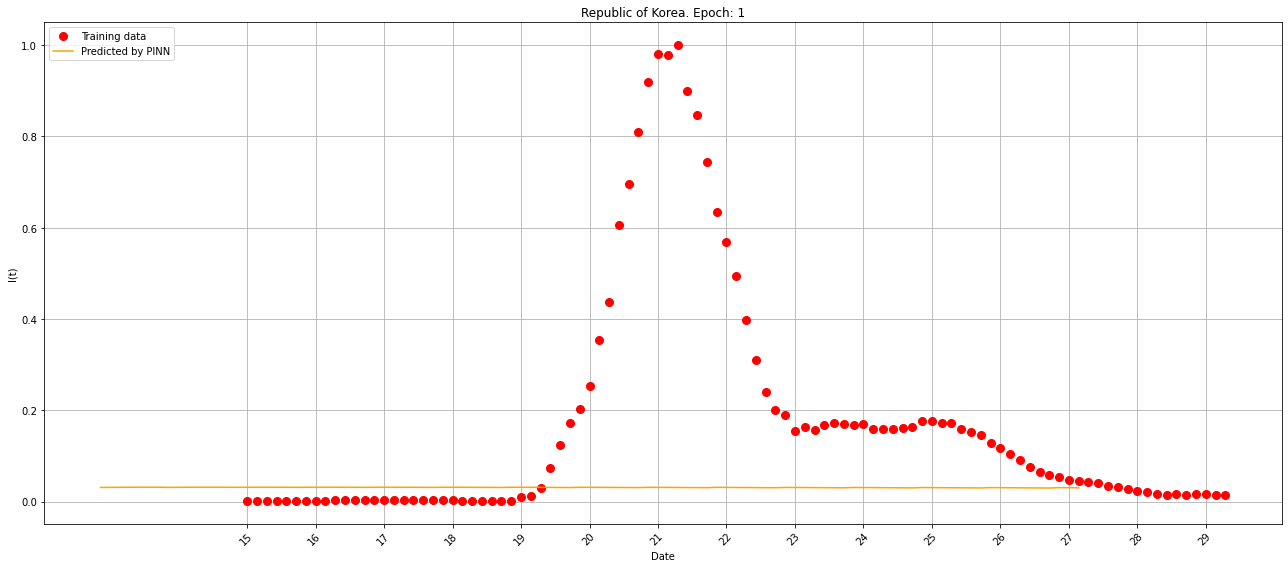

Epoch 101, MSE Loss = 0.0012295361375436187, SIR Loss = 0.0, Average Loss = 0.06987588671896584
Epoch 201, MSE Loss = 8.272717241197824e-05, SIR Loss = 0.0, Average Loss = 0.0744425373602114
Epoch 301, MSE Loss = 0.00021869342890568078, SIR Loss = 0.0, Average Loss = 0.07523129045674042
Epoch 401, MSE Loss = 3.6764809919986874e-05, SIR Loss = 0.0, Average Loss = 0.07522476488058955
Epoch 501, MSE Loss = 7.518440543208271e-05, SIR Loss = 0.0, Average Loss = 0.07516919264382088
Epoch 601, MSE Loss = 3.692979225888848e-05, SIR Loss = 0.0, Average Loss = 0.07519229728454167
Epoch 701, MSE Loss = 3.6157958675175905e-05, SIR Loss = 0.0, Average Loss = 0.07519215219285078
Epoch 801, MSE Loss = 3.590955748222768e-05, SIR Loss = 0.0, Average Loss = 0.07519174352218708
Epoch 901, MSE Loss = 3.563414793461561e-05, SIR Loss = 0.0, Average Loss = 0.07519226182237691
Epoch 1001, MSE Loss = 3.5695527913048863e-05, SIR Loss = 0.0, Average Loss = 0.07519226702794976


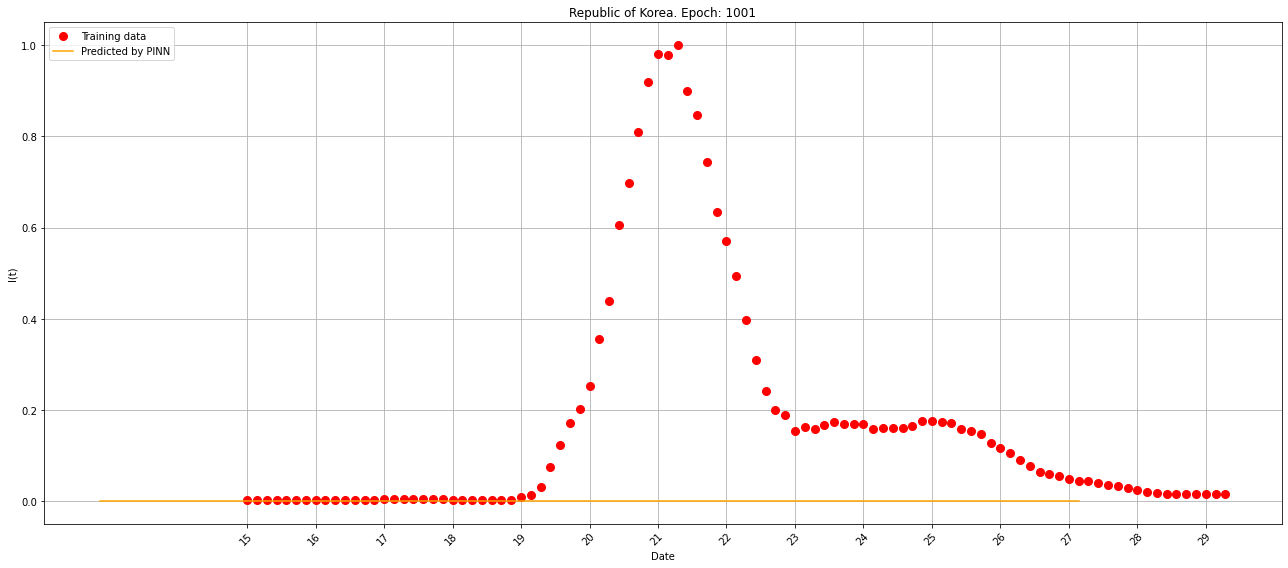

Early stopping at epoch 1002.
Epoch 1, MSE Loss = 0.0009716060012578964, SIR Loss = 0.0, Average Loss = 0.07004577482341741


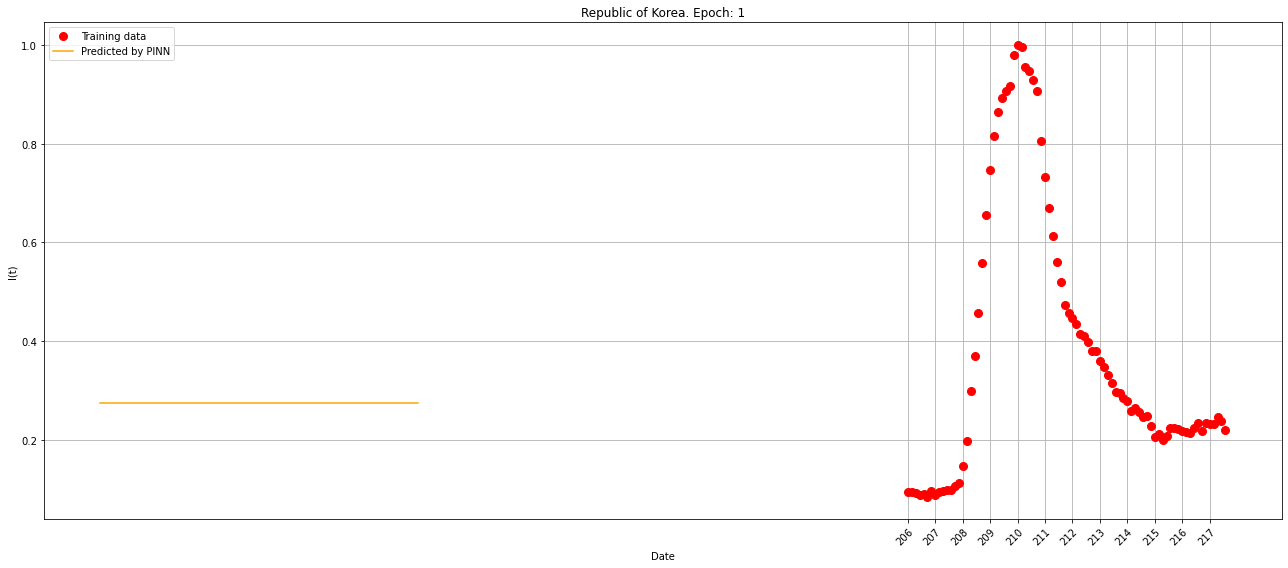

Epoch 101, MSE Loss = 0.0010088247945532203, SIR Loss = 0.0, Average Loss = 0.0840209217762671
Epoch 201, MSE Loss = 0.0010087970877066255, SIR Loss = 0.0, Average Loss = 0.08402177280660864
Epoch 301, MSE Loss = 0.0010087963892146945, SIR Loss = 0.0, Average Loss = 0.08402176142071101
Epoch 401, MSE Loss = 0.0010087986011058092, SIR Loss = 0.0, Average Loss = 0.08402176282222017
Epoch 501, MSE Loss = 0.0010087969712913036, SIR Loss = 0.0, Average Loss = 0.08402176003668191


KeyboardInterrupt: 

In [16]:
#autoregressive training version
def train_autoregressive(model, optimizer, t_train, y_train, sigma, sigma0, mu, epochs, patience, display_step, date_ticks, country):
    """
    Train the model using autoregressive learning.
    
    Parameters:
        model: PINN model
        optimizer: Optimizer
        t_train: Training time data
        y_train: Training infection data
        sigma, sigma0, mu: SIR model parameters
        epochs: Total epochs
        patience: Early stopping patience
        display_step: Steps to visualize predictions
        date_ticks: Time labels for plots
        country: Country name for visualization
    """
    early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
    losses = []

    # Number of autoregressive steps (how far ahead to predict at each iteration)
    ar_steps = 7  # Predict one week ahead

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for i in range(len(t_train) - ar_steps):
            t_input = t_train[i:i+ar_steps].view(-1, 1)
            y_target = y_train[i+1:i+ar_steps+1].view(-1, 1)

            optimizer.zero_grad()

            # Predict next step(s)
            y_pred = model(t_input)
            mse_loss = MSE_loss(y_target, y_pred)
            sir_loss = SIR_loss(model, t_input, sigma, sigma0, mu)

            # Combine losses
            loss = mse_loss + sir_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(t_train) - ar_steps)
        losses.append(avg_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Average Loss = {avg_loss}")

        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = autoregressive_predict(model, t_train[:ar_steps], len(t_train) - ar_steps, delta_t=1)
                # Ensure dimensions match for plotting
                predicted_values = predicted_values[:len(t_train) - ar_steps]  # Slice to match y_data
                plot_predictions(
                    t_data=t_train[:len(predicted_values)].numpy(),  # Match length with predictions
                    y_data=y_train[:len(predicted_values)].numpy(),  # Match length with predictions
                    t_predict=np.arange(len(predicted_values)),      # Generate matching x-axis for predictions
                    predicted_values=np.array(predicted_values),
                    date_ticks=date_ticks,
                    country=country,
                    epoch=epoch,
                )

        if early_stopping.check_early_stopping(avg_loss, epoch):
            break

    return losses

def autoregressive_predict(model, t_initial, steps, delta_t):
    """
    Predict future values in an autoregressive manner with multi-step outputs.
    
    Parameters:
        model: Trained PINN model
        t_initial: Initial time steps (torch.tensor)
        steps: Number of future steps to predict
        delta_t: Step size for time
    
    Returns:
        Predicted values (list)
    """
    model.eval()
    predictions = []
    t_current = t_initial.clone()  # Start with the full initial window

    with torch.no_grad():
        for _ in range(steps):
            # Predict the next set of values
            next_values = model(t_current).view(-1).tolist()  # Convert tensor to list
            predictions.extend(next_values)  # Append predictions

            # Update time for the next step
            t_next = t_current[-1] + delta_t
            t_current = torch.cat([t_current[1:], t_next.view(1, -1)], dim=0)

    return predictions

# Initialize the model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model using autoregressive learning
for country in training_coutries:
    for wave in data[country]:
        t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1)
        y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1)

        t_train = t_data
        y_train = y_data / max(y_data)  # Normalize data

        losses = train_autoregressive(
            model=model,
            optimizer=optimizer,
            t_train=t_train,
            y_train=y_train,
            sigma=sigma,
            sigma0=sigma0,
            mu=mu,
            epochs=10000,
            patience=1000,
            display_step=1000,
            date_ticks=time_data[country][wave],
            country=country
        )

        # Save the model for this wave
        torch.save(model.state_dict(), f"models/{country}_wave_{wave}_ar.pt")